In [58]:
# Imports
from vespa.package import (
    ApplicationPackage,
    Field,
    Schema,
    Document,
    HNSW,
    RankProfile,
    Component,
    Parameter,
    FieldSet,
    GlobalPhaseRanking,
    Function,
    OnnxModel,
    SecondPhaseRanking
)

from tqdm import tqdm

In [59]:
# Replace with your tenant name from the Vespa Cloud Console
tenant_name = "fgv-pcd251"
# Replace with your application name (does not need to exist yet)
application = "hybridsearch"

In [60]:
class MySchema(Schema):
    @property
    def schema_to_text(self):
        og_text = super().schema_to_text
        og_text = og_text.replace("\\", "/")
        return og_text

package = ApplicationPackage(
    name=application,
    schema=[
        MySchema(
            name="doc",
            document=Document(
                fields=[
                    Field(name="id", type="string", indexing=["summary"]),
                    Field(
                        name="text",
                        type="string",
                        indexing=["index", "summary"],
                        index="enable-bm25",
                        bolding=True,
                    ),
                    Field(
                        name="embedding",
                        type="tensor<float>(x[384])",
                        indexing=[
                            'input text',
                            "embed mini",
                            "index",
                            "attribute",
                        ],
                        ann=HNSW(distance_metric="angular"),
                        is_document_field=False,
                    ),
                    Field(
                        name="colbert_embedding",
                        type="tensor<int8>(dt{}, x[16])",
                        indexing=["input text", "embed colbert", "attribute"],
                        attribute=["paged"],
                        is_document_field=False,
                    ),
                    Field(
                        name="text_tokens_ids",
                        type="tensor<float>(d0[64])",
                        indexing=["input text", "embed tokenizer", "attribute"],
                        attribute=["paged"],
                        is_document_field=False,
                    ),
                ]
            ),
            fieldsets=[FieldSet(name="default", fields=["text"])],
            models = [
                OnnxModel(
                    model_name="ranker",
                    model_file_path="models/model.onnx",
                    inputs={
                        "input_ids": "input_ids",
                        "attention_mask": "attention_mask",
                        "token_type_ids": "token_type_ids",
                    },
                    outputs={"logits": "logits"},
                )
            ],
            rank_profiles=[
                RankProfile(
                    name="bm25",
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    functions=[
                        Function(name="bm25text", expression="bm25(text)")
                    ],
                    first_phase="bm25text",
                    match_features=["bm25text"],
                ),
                RankProfile(
                    name="dot_product",
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    functions=[
                        Function(
                            name="cos_sim", expression="closeness(field, embedding)"
                        )
                    ],
                    first_phase="cos_sim",
                    match_features=["cos_sim"],
                ),
                RankProfile(
                    name="fusion",
                    inherits="bm25",
                    functions=[
                        Function(
                            name="cos_sim", expression="closeness(field, embedding)"
                        )
                    ],
                    inputs=[("query(q)", "tensor<float>(x[384])")],
                    first_phase="cos_sim",
                    global_phase=GlobalPhaseRanking(
                        expression="reciprocal_rank_fusion(bm25text, closeness(field, embedding))",
                        rerank_count=1000,
                    ),
                    match_features=["cos_sim", "bm25text"],
                ),
                RankProfile(
                    name="dot_product_colbert",
                    inherits="dot_product",
                    inputs=[
                        ("query(q)", "tensor<float>(x[384])"),
                        ("query(qt)", "tensor<float>(qt{}, x[128])")
                    ],
                    first_phase="cos_sim",
                    functions=[
                        Function(
                            name="cos_sim", expression="closeness(field, embedding)"
                        ),
                        Function(name="max_sim", expression="""
                                sum(
                                    reduce(
                                        sum(
                                            query(qt) * unpack_bits(attribute(colbert_embedding)), x
                                        ),
                                        max, dt
                                    ),
                                    qt
                                )
                                """
                        ),
                    ],
                    second_phase=SecondPhaseRanking(
                        expression="max_sim",
                        rerank_count=100,
                    ),
                    match_features=["cos_sim", "max_sim"],
                ),
                RankProfile(
                    name="dot_product_cross_encoder",
                    inputs=[("query(q)", "tensor<float>(x[384])"), ("query(qt)", "tensor<float>(qt{}, x[128])"), ("query(query_token_ids)", "tensor<float>(d0[32])")],
                    functions=[
                        Function(name="cos_sim", expression="closeness(field, embedding)"),
                        Function(name="input_ids", expression="tokenInputIds(96, query(query_token_ids), attribute(text_tokens_ids))"),
                        Function(name="token_type_ids", expression="tokenTypeIds(96, query(query_token_ids), attribute(text_tokens_ids))"),
                        Function(name="attention_mask", expression="tokenAttentionMask(96, query(query_token_ids), attribute(text_tokens_ids))"),
                        Function(name="cross_encoder", expression="onnx(ranker){d0:0,d1:0}"),
                    ],
                    first_phase="cos_sim",
                    second_phase=SecondPhaseRanking(
                        expression="cross_encoder",
                        rerank_count=100,
                    ),
                    match_features=["cos_sim", "cross_encoder"],
                )
            ],
        )
    ],
    components=[
        Component(
            id="mini",
            type="hugging-face-embedder",
            parameters=[
                Parameter(
                    "transformer-model",
                    {
                        "url": "https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/resolve/main/onnx/model.onnx",
                    },
                ),
                Parameter(
                    "tokenizer-model",
                    {
                        "url": "https://huggingface.co/sentence-transformers/all-MiniLM-L6-v2/raw/main/tokenizer.json",
                    },
                ),
            ],
        ),
        Component(
            id="colbert",
            type="colbert-embedder",
            parameters=[
                Parameter(
                    "transformer-model",
                    {
                        "url": "https://huggingface.co/colbert-ir/colbertv2.0/resolve/main/model.onnx",
                    },
                ),
                Parameter(
                    "tokenizer-model",
                    {
                        "url": "https://huggingface.co/colbert-ir/colbertv2.0/raw/main/tokenizer.json",
                    },
                ),
            ],
        ),
        Component(
            id="tokenizer",
            type="hugging-face-tokenizer",
            parameters=[
                Parameter("model", {"url": "https://huggingface.co/Xenova/ms-marco-MiniLM-L-6-v2/raw/main/tokenizer.json"})
            ]
        ),
    ],
)

In [62]:
from vespa.deployment import VespaCloud
import os

# Key is only used for CI/CD. Can be removed if logging in interactively
key = os.getenv("VESPA_TEAM_API_KEY", None)
if key is not None:
    key = key.replace(r"\n", "\n")  # To parse key correctly

vespa_cloud = VespaCloud(
    tenant=tenant_name,
    application=application,
    key_content=key,  # Key is only used for CI/CD. Can be removed if logging in interactively
    application_package=package,
)

Setting application...
Running: vespa config set application fgv-pcd251.hybridsearch.default
Setting target cloud...
Running: vespa config set target cloud

No api-key found for control plane access. Using access token.
Checking for access token in auth.json...
Successfully obtained access token for control plane access.


In [63]:
app = vespa_cloud.deploy()

Deployment started in run 41 of dev-aws-us-east-1c for fgv-pcd251.hybridsearch. This may take a few minutes the first time.
INFO    [21:59:24]  Deploying platform version 8.537.21 and application dev build 36 for dev-aws-us-east-1c of default ...
INFO    [21:59:31]  Using CA signed certificate version 1
WARNING [21:59:32]  Expected newline between inputs query(q) and query(qt)
WARNING [21:59:32]  Expected newline between inputs query(q) and query(qt)
WARNING [21:59:32]  Expected newline between inputs query(qt) and query(query_token_ids)
INFO    [21:59:32]  Using 1 nodes in container cluster 'hybridsearch_container'
WARNING [21:59:35]  Cluster 'hybridsearch_content' has nodes with remote storage and fields with paged attributes. This might lead to performance issues when doing I/O. Consider using storage-type='local' or removing 'paged' setting for these fields: 'colbert_embedding', 'text_tokens_ids', 'colbert_embedding', 'text_tokens_ids'
INFO    [21:59:37]  Session 179 for tenant 'fg

In [64]:
endpoint = vespa_cloud.get_mtls_endpoint()
endpoint

Found mtls endpoint for hybridsearch_container
URL: https://c6a95113.b5b9be04.z.vespa-app.cloud/


'https://c6a95113.b5b9be04.z.vespa-app.cloud/'

In [65]:
import random
import pickle

PATH = 'subset_msmarco_train_0.01_9.pkl'
PATH_DATA = '../data/' + PATH

with open(PATH_DATA, "rb") as f:
    data = pickle.load(f)

queries = data["queries"]
query_ids = list(queries.keys())

random.shuffle(query_ids)

train_query_ids = query_ids[:int(len(query_ids) * 0.8)]
test_query_ids = query_ids[int(len(query_ids) * 0.8):]

train_queries = {qid: queries[qid] for qid in train_query_ids}
test_queries = {qid: queries[qid] for qid in test_query_ids}

qrels = data["qrels"]
docs = data["docs"]
vespa_feed = [{"id": doc_id, "fields": {"text": doc_obj.text, "id": doc_id}} for doc_id, doc_obj in docs.items()]

In [66]:
from vespa.io import VespaResponse, VespaQueryResponse
import time

def callback(response: VespaResponse, id: str):
    # print(f"Document {id}: {response.get_status_code()}")
    print(f"Feeding document {id}: {response.get_json()}")
    time.sleep(0.1)  # To avoid overwhelming the server with requests
    if not response.is_successful():
        print(f"Error when feeding document {id}: {response.get_json()}")


app.feed_iterable(vespa_feed, schema="doc", namespace="tutorial", callback=callback)

Feeding document msmarco_passage_31_315887924: {'Exception': '401 Client Error: Unauthorized for url: https://c6a95113.b5b9be04.z.vespa-app.cloud//document/v1/tutorial/doc/docid/msmarco_passage_31_315887924', 'id': 'msmarco_passage_31_315887924', 'message': 'Exception during feed_data_point'}
Error when feeding document msmarco_passage_31_315887924: {'Exception': '401 Client Error: Unauthorized for url: https://c6a95113.b5b9be04.z.vespa-app.cloud//document/v1/tutorial/doc/docid/msmarco_passage_31_315887924', 'id': 'msmarco_passage_31_315887924', 'message': 'Exception during feed_data_point'}
Feeding document msmarco_passage_31_211784428: {'pathId': '/document/v1/tutorial/doc/docid/msmarco_passage_31_211784428', 'id': 'id:tutorial:doc::msmarco_passage_31_211784428'}
Feeding document msmarco_passage_04_6923031: {'pathId': '/document/v1/tutorial/doc/docid/msmarco_passage_04_6923031', 'id': 'id:tutorial:doc::msmarco_passage_04_6923031'}
Feeding document msmarco_passage_31_15605486: {'pathI

In [67]:
import pandas as pd

def display_hits_as_df(response: VespaQueryResponse, fields) -> pd.DataFrame:
    records = []
    for hit in response.hits:
        record = {}
        for field in fields:
            record[field] = hit["fields"][field]
        records.append(record)
    return pd.DataFrame(records)

In [68]:
with app.syncio(connections=1) as session:
    query = "How Fruits and Vegetables Can Treat Asthma?"
    response: VespaQueryResponse = session.query(
        yql="select * from sources * where userQuery() limit 5",
        query=query,
        ranking="bm25",
    )
    assert response.is_successful()
    print(display_hits_as_df(response, ["id", "text"]))

                             id  \
0   msmarco_passage_02_52587316   
1  msmarco_passage_00_424519135   
2  msmarco_passage_01_310865328   
3  msmarco_passage_04_194723288   
4  msmarco_passage_01_581276311   

                                                text  
0  Produce <hi>can</hi> be tricky to store becaus...  
1  <hi>Vegetables</hi> <hi>and</hi> <hi>fruits</h...  
2  It helps with digestion but few people are get...  
3  <hi>How</hi> much fat do women need? About 40%...  
4  Certain <hi>vegetables</hi>: tomato, spinach, ...  


In [78]:
with app.syncio(connections=1) as session:
    query = "How Fruits and Vegetables Can Treat Asthma?"
    response: VespaQueryResponse = session.query(
        yql="select * from sources * where ({targetHits:5}nearestNeighbor(embedding,q)) limit 5",
        query=query,
        ranking="dot_product",
        body={"input.query(q)": f"embed(mini, \"{query}\")"},
    )
    assert response.is_successful()
    print(display_hits_as_df(response, ["id", "text"]))

                             id  \
0  msmarco_passage_00_429510381   
1  msmarco_passage_06_250080986   
2  msmarco_passage_01_581276311   
3  msmarco_passage_03_847886742   
4  msmarco_passage_03_130922887   

                                                text  
0  Bring on the Rainbow of Fruit. I’m talking abo...  
1  Carrots Pack Anti-Arthritis Vitamin A and Beta...  
2  Certain vegetables: tomato, spinach, eggplant,...  
3  Surgery, sprains and strains and tendinitis. S...  
4  I believe this is a massive help to reduce psa...  


In [79]:
with app.syncio(connections=1) as session:
    query = "How Fruits and Vegetables Can Treat Asthma?"
    response: VespaQueryResponse = session.query(
        yql="select * from sources * where userQuery() or ({targetHits:1000}nearestNeighbor(embedding,q)) limit 5",
        query=query,
        ranking="fusion",
        body={"input.query(q)": f"embed(mini, \"{query}\")"},
    )
    assert response.is_successful()
    print(display_hits_as_df(response, ["id", "text"]))

                             id  \
0  msmarco_passage_01_581276311   
1  msmarco_passage_04_709211700   
2  msmarco_passage_01_311869046   
3  msmarco_passage_10_733014504   
4  msmarco_passage_01_520646272   

                                                text  
0  Certain <hi>vegetables</hi>: tomato, spinach, ...  
1  Sharing <hi>asthma</hi> inhalers <hi>can</hi> ...  
2  Vegetarian sources of protein – legumes (dry b...  
3  <hi>Asthma</hi> is one of the most common chro...  
4  <hi>Asthma</hi> Symptoms Hinder Children’s Sle...  


In [80]:
with app.syncio(connections=1) as session:
    query = "How Fruits and Vegetables Can Treat Asthma?"
    response: VespaQueryResponse = session.query(
        yql="select * from sources * where rank({targetHits:1000}nearestNeighbor(embedding,q), userQuery()) limit 5",
        query=query,
        ranking="fusion",
        body={"input.query(q)": f"embed(mini, \"{query}\")"},
    )
    assert response.is_successful()
    print(display_hits_as_df(response, ["id", "text"]))

                             id  \
0  msmarco_passage_01_581276311   
1  msmarco_passage_04_709211700   
2  msmarco_passage_01_311869046   
3  msmarco_passage_10_733014504   
4  msmarco_passage_01_520646272   

                                                text  
0  Certain <hi>vegetables</hi>: tomato, spinach, ...  
1  Sharing <hi>asthma</hi> inhalers <hi>can</hi> ...  
2  Vegetarian sources of protein – legumes (dry b...  
3  <hi>Asthma</hi> is one of the most common chro...  
4  <hi>Asthma</hi> Symptoms Hinder Children’s Sle...  


In [81]:
with app.syncio(connections=1) as session:
    query = "How Fruits and Vegetables Can Treat Asthma?"
    response: VespaQueryResponse = session.query(
        yql='select * from sources * where text contains "vegetable" and rank({targetHits:1000}nearestNeighbor(embedding,q), userQuery()) limit 5',
        query=query,
        ranking="fusion",
        body={"input.query(q)": f"embed(mini, \"{query}\")"},
    )
    assert response.is_successful()
    print(display_hits_as_df(response, ["id", "text"]))

                             id  \
0  msmarco_passage_01_581276311   
1   msmarco_passage_02_52587316   
2  msmarco_passage_01_311869046   
3  msmarco_passage_01_310865328   
4  msmarco_passage_00_194815263   

                                                text  
0  Certain <hi>vegetables</hi>: tomato, spinach, ...  
1  Produce <hi>can</hi> be tricky to store becaus...  
2  Vegetarian sources of protein – legumes (dry b...  
3  It helps with digestion but few people are get...  
4  <hi>Vegetables</hi> like cucumber, spinach, ca...  


In [112]:
from vespa.evaluation import VespaEvaluator

?VespaEvaluator

Init signature:
VespaEvaluator(
    queries: 'Dict[str, str]',
    relevant_docs: 'Union[Dict[str, Union[Set[str], Dict[str, float]]], Dict[str, str]]',
    vespa_query_fn: 'Callable[[str, int, Optional[str]], dict]',
    app: 'Vespa',
    name: 'str' = '',
    id_field: 'str' = '',
    accuracy_at_k: 'List[int]' = [1, 3, 5, 10],
    precision_recall_at_k: 'List[int]' = [1, 3, 5, 10, 100],
    mrr_at_k: 'List[int]' = [10],
    ndcg_at_k: 'List[int]' = [10],
    map_at_k: 'List[int]' = [100],
    write_csv: 'bool' = False,
    csv_dir: 'Optional[str]' = None,
)
Docstring:     
Evaluate retrieval performance on a Vespa application.

This class:

- Iterates over queries and issues them against your Vespa application.
- Retrieves top-k documents per query (with k = max of your IR metrics).
- Compares the retrieved documents with a set of relevant document ids.
- Computes IR metrics: Accuracy@k, Precision@k, Recall@k, MRR@k, NDCG@k, MAP@k.
- Logs vespa search times for each query.
- Logs/re

In [113]:
import vespa.querybuilder as qb

def lexical_bm25_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": "select * from sources * where userQuery();", 
        "query": query_text,
        "ranking": "bm25",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }

def lexical_dot_product_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": "select * from sources * where userQuery();",
        "query": query_text,
        "ranking": "dot_product",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }

def lexical_fusion_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": "select * from sources * where userQuery();",
        "query": query_text,
        "ranking": "fusion",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }

def semantic_bm25_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
            )
        ),
        "query": query_text,
        "ranking": "bm25",
        "input.query(q)": f"embed(mini, \"{query_text}\")",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }

def semantic_dot_product_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
            )
        ),
        "query": query_text,
        "ranking": "dot_product",
        "input.query(q)": f"embed(mini, \"{query_text}\")",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }

def semantic_fusion_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
            )
        ),
        "query": query_text,
        "ranking": "fusion",
        "input.query(q)": f"embed(mini, \"{query_text}\")",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }

def hybrid_bm25_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        "query": query_text,
        "ranking": "bm25",
        "input.query(q)": f"embed(mini, \"{query_text}\")",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }

def hybrid_dot_product_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        "query": query_text,
        "ranking": "dot_product",
        "input.query(q)": f"embed(mini, \"{query_text}\")",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }
    
def hybrid_dot_product_colbert_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        "query": query_text,
        "ranking": "dot_product_colbert",
        "input.query(q)": f"embed(mini, \"{query_text}\")",
        "input.query(qt)": f"embed(colbert, \"{query_text}\")",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }
    
def hybrid_dot_product_cross_encoder_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        "query": query_text,
        "ranking": "dot_product_cross_encoder",
        "input.query(q)": f"embed(mini, \"{query_text}\")",
        "input.query(query_token_ids)": f"embed(tokenizer, \"{query_text}\")",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }

def hybrid_fusion_query_fn(query_text: str, top_k: int) -> dict:
    return {
        "yql": str(
            qb.select("*")
            .from_("doc")
            .where(
                qb.nearestNeighbor(
                    field="embedding",
                    query_vector="q",
                    annotations={"targetHits": 1000},
                )
                | qb.userQuery(query_text)
            )
        ),
        "query": query_text,
        "ranking": "fusion",
        "input.query(q)": f"embed(mini, \"{query_text}\")",
        "hits": top_k,
        "timeout": 10,
        "ranking.softtimeout.enable": "false",
    }


In [114]:
from vespa.io import VespaQueryResponse

response: VespaQueryResponse = app.query(
    body=semantic_bm25_query_fn("how to bake a cake", 3)
)

In [90]:
response.get_json()

{'root': {'id': 'toplevel',
  'relevance': 1.0,
  'fields': {'totalCount': 1000},
  'coverage': {'coverage': 100,
   'documents': 27776,
   'full': True,
   'nodes': 1,
   'results': 1,
   'resultsFull': 1},
  'children': [{'id': 'id:tutorial:doc::msmarco_passage_04_7051408',
    'relevance': 0.0,
    'source': 'hybridsearch_content',
    'fields': {'matchfeatures': {'bm25text': 0.0},
     'sddocname': 'doc',
     'text': 'Sow seeds directly into the garden once the soil is warm in the spring. You can start seeds indoors, but they germinate so easily outside that there’s really no advantage. The exception is African marigolds, which are best bought as young plants or started indoors about 4 to 6 weeks before your last frost date.',
     'documentid': 'id:tutorial:doc::msmarco_passage_04_7051408',
     'id': 'msmarco_passage_04_7051408'}},
   {'id': 'id:tutorial:doc::msmarco_passage_04_89901538',
    'relevance': 0.0,
    'source': 'hybridsearch_content',
    'fields': {'matchfeatures':

In [91]:
ids_to_queries = {query.query_id: query.text for query in train_queries.values()}

for i in range(5):
    query_id = list(ids_to_queries.keys())[i]
    print(f"Query ID: {query_id}, Query Text: {ids_to_queries[query_id]}")

Query ID: 765614, Query Text: what is lichenoid keratosis
Query ID: 732362, Query Text: what is combined chlorine in pools
Query ID: 130908, Query Text: definition for justice
Query ID: 476996, Query Text: population distribution of africa
Query ID: 1034247, Query Text: who is jeremy renner actor


In [92]:
relevant_docs = {}
for qrel in qrels:
    query_id = qrel.query_id
    doc_id = qrel.doc_id
    if query_id not in relevant_docs:
        relevant_docs[query_id] = set()
    relevant_docs[query_id].add(doc_id)

for i in range(5):
    query_id = list(relevant_docs.keys())[i]
    print(f"Query ID: {query_id}, Relevant Docs: {relevant_docs[query_id]}")

Query ID: 135841, Relevant Docs: {'msmarco_passage_16_93510573'}
Query ID: 1072113, Relevant Docs: {'msmarco_passage_03_76282697'}
Query ID: 66325, Relevant Docs: {'msmarco_passage_03_779837601'}
Query ID: 622007, Relevant Docs: {'msmarco_passage_18_4266000'}
Query ID: 406188, Relevant Docs: {'msmarco_passage_58_532087922'}


In [ ]:
# from collections import defaultdict

# ids_to_queries = {qid: q.text for qid, q in data["queries"].items()}

# relevant_docs = defaultdict(set)

# for qid, _, docid, score in data["qrels"]:
#     if int(score) > 0:
#         relevant_docs[qid].add(docid)
        
# relevant_docs = dict(relevant_docs)

In [115]:
all_results = {}
for evaluator_name, query_fn in [
    ("lexical_b25", lexical_bm25_query_fn),
    ("lexical_dot_product", lexical_dot_product_query_fn),
    ("lexical_fusion", lexical_fusion_query_fn),
    ("semantic_bm25", semantic_bm25_query_fn),
    ("semantic_dot_product", semantic_dot_product_query_fn),
    ("semantic_fusion", semantic_fusion_query_fn),
    ("hybrid_bm25", hybrid_bm25_query_fn),
    ("hybrid_dot_product", hybrid_dot_product_query_fn),
    ("hybrid_fusion", hybrid_fusion_query_fn),
    ("hybrid_dot_product_colbert", hybrid_dot_product_colbert_query_fn),
    ("hybrid_dot_product_cross_encoder", hybrid_dot_product_cross_encoder_query_fn)
]:
    print(f"Evaluating {evaluator_name}...")
    evaluator = VespaEvaluator(
        queries=ids_to_queries,  
        relevant_docs=relevant_docs,
        vespa_query_fn=query_fn,
        app=app,
        name=evaluator_name,
        precision_recall_at_k=[1, 3, 5, 10, 100],
        write_csv=True,  # optionally write metrics to CSV
    )

    results = evaluator.run()
    all_results[evaluator_name] = results

Evaluating lexical_b25...
Evaluating lexical_dot_product...
Evaluating lexical_fusion...
Evaluating semantic_bm25...
Evaluating semantic_dot_product...
Evaluating semantic_fusion...
Evaluating hybrid_bm25...
Evaluating hybrid_dot_product...
Evaluating hybrid_fusion...
Evaluating hybrid_dot_product_colbert...


RetryError: RetryError[<Future at 0x269042e86d0 state=finished raised ReadTimeout>]

In [94]:
import pandas as pd

results = pd.DataFrame(all_results)

In [95]:
# take out all rows with "searchtime" to a separate dataframe
searchtime = results[results.index.str.contains("searchtime")]
results = results[~results.index.str.contains("searchtime")]


# Highlight the maximum value in each row
def highlight_max(s):
    is_max = s == s.max()
    return ["background-color: lightgreen; color: black;" if v else "" for v in is_max]


# Style the DataFrame: Highlight max values and format numbers to 4 decimals
styled_df = results.style.apply(highlight_max, axis=1).format("{:.4f}")
styled_df

<Axes: >

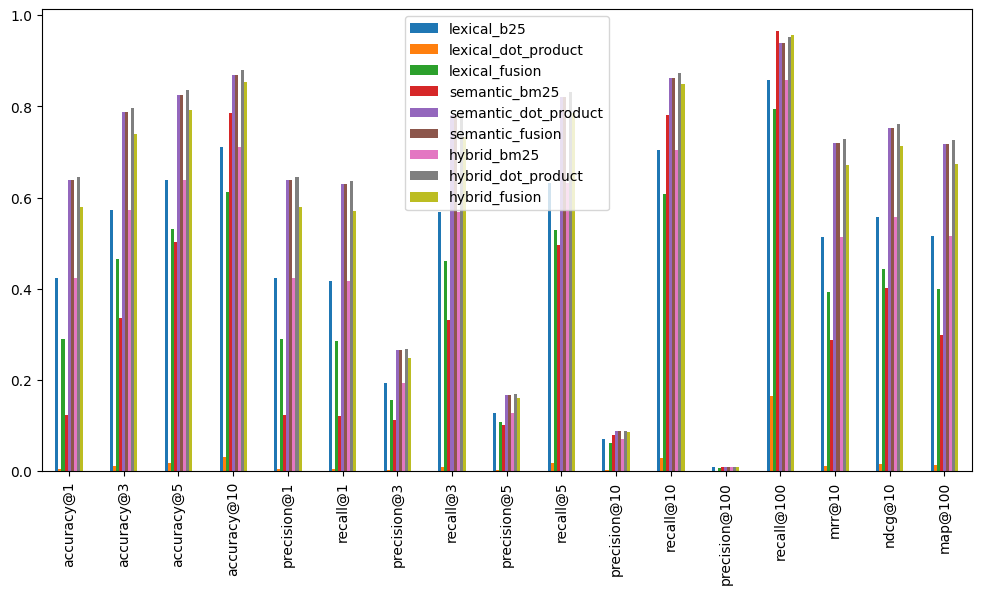

In [ ]:
results.plot(kind="bar", figsize=(12, 6))

[Text(0, 0.5, 'time (ms)')]

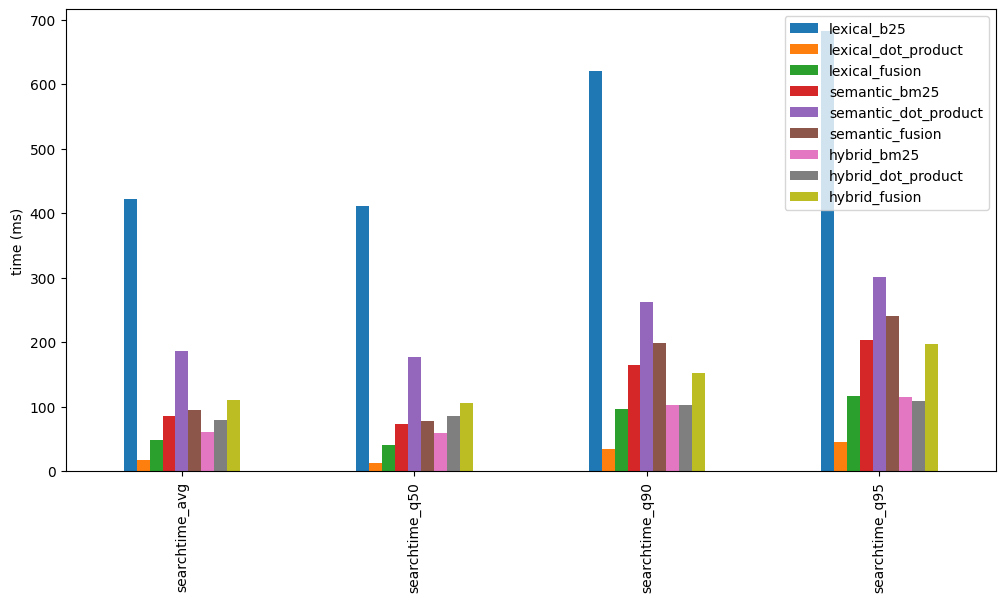

In [ ]:
# plot search time, add (ms) to the y-axis
# convert to ms
searchtime = searchtime * 1000
searchtime.plot(kind="bar", figsize=(12, 6)).set(ylabel="time (ms)")

In [51]:
def calculate_mrr_at_10(results: dict, relevant_docs: dict) -> float:
    """
    Calcula o MRR@10 para um conjunto de queries.

    Parâmetros:
        - results: dict {query_id: list of predicted doc_ids em ordem ranqueada}
        - relevant_docs: dict {query_id: set of ground-truth relevant doc_ids}

    Retorna:
        - MRR@10 (float)
    """
    reciprocal_ranks = []
    for query_id, predicted_doc_ids in results.items():
        found = False
        for rank, doc_id in enumerate(predicted_doc_ids[:10], start=1):
            if doc_id in relevant_docs.get(query_id, set()):
                reciprocal_ranks.append(1.0 / rank)
                found = True
                break
        if not found:
            reciprocal_ranks.append(0.0)
    return sum(reciprocal_ranks) / len(reciprocal_ranks) if reciprocal_ranks else 0.0


In [56]:
def calculate_recall_at_k(results: dict, relevant_docs: dict, k: int) -> float:
    """
    Calcula o Recall@k para um conjunto de queries.

    Parâmetros:
        - results: dict {query_id: list of predicted doc_ids em ordem ranqueada}
        - relevant_docs: dict {query_id: set of ground-truth relevant doc_ids}
        - k: int, número de documentos considerados para o recall

    Retorna:
        - Recall@k (float)
    """
    total_recall = 0.0
    for query_id, predicted_doc_ids in results.items():
        relevant_set = relevant_docs.get(query_id, set())
        if not relevant_set:
            continue
        predicted_set = set(predicted_doc_ids[:k])
        recall = len(predicted_set & relevant_set) / len(relevant_set)
        total_recall += recall
        
    return total_recall / len(results) if results else 0.0

In [52]:
from sentence_transformers import CrossEncoder

def rerank_cross_encoder(query_text, docs, top_k=10):
    """
    Rerank documentos com base em um Cross-Encoder.
    
    Parâmetros:
        query_text: str, o texto da query
        docs: list of tuples (text, doc_id)
        top_k: int, número de documentos reranqueados a retornar

    Retorna:
        Lista de tuplas (doc_text, doc_id, score) ordenada por score decrescente
    """
    # Inicializa o modelo (você pode mover isso para fora da função depois se quiser)
    model = CrossEncoder("cross-encoder/ms-marco-MiniLM-L-6-v2")

    # Monta os pares (query, doc_text)
    pairs = [(query_text, doc_text) for (doc_text, _) in docs]

    # Reranqueia
    scores = model.predict(pairs)

    # Associa cada score ao seu texto e ID original
    scored_docs = [(doc_text, doc_id, score) for ((doc_text, doc_id), score) in zip(docs, scores)]

    # Ordena por score decrescente
    reranked = sorted(scored_docs, key=lambda x: x[2], reverse=True)

    return reranked[:top_k]


c:\Users\gabri\anaconda3\envs\vespa-env\lib\site-packages\tqdm\auto.py:21: TqdmWarning:

IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html



In [54]:
# Escolhe um qid válido (exemplo: o primeiro da lista)
qid = list(queries.keys())[0]

# Extrai o texto da query
query_text = queries[qid].text

# Extrai os documentos do response (certifique-se de ter executado uma busca antes!)
docs = [(hit["fields"]["text"], hit["id"]) for hit in response.hits]

# Reranqueia com Cross-Encoder (assumindo que a função rerank_cross_encoder já está definida)
reranked_docs = rerank_cross_encoder(query_text, docs, top_k=10)

# Mostra os resultados reranqueados
for text, doc_id, score in reranked_docs:
    print(f"{doc_id} → {score:.4f}")


id:tutorial:doc::msmarco_passage_63_688083500 → -10.9786
id:tutorial:doc::msmarco_passage_10_517985636 → -11.1884
id:tutorial:doc::msmarco_passage_04_98433340 → -11.2454


In [63]:
import time

results = {}
rerank_times = []

for qid in tqdm(list(relevant_docs.keys())[:50], desc="Reranking"):
    query_text = queries[qid].text

    # Recupera documentos do Vespa com top_k inicial (por exemplo, 100)
    response = app.query(body=hybrid_dot_product_query_fn(query_text, top_k=100))
    docs = [(hit["fields"]["text"], hit["id"].replace("id:tutorial:doc::", "")) for hit in response.hits]

    # Reranqueia com Cross-Encoder
    start_time = time.time()
    reranked_docs = rerank_cross_encoder(query_text, docs, top_k=10)
    end_time = time.time()
    
    # Calcula o tempo de reranqueamento
    time_taken = end_time - start_time
    rerank_times.append(time_taken)

    # Armazena apenas os doc_ids reranqueados
    results[qid] = [doc_id for _, doc_id, _ in reranked_docs]

# Calcula MRR@10
mrr = calculate_mrr_at_10(results, relevant_docs)
print(f"MRR@10: {mrr:.4f}")

# Calcula Recall@100
recall = calculate_recall_at_k(results, relevant_docs, k=100)
print(f"Recall@100: {recall:.4f}")

# Tempo médio por query
avg_time = sum(rerank_times) / len(rerank_times)
print(f"\nAverage reranking time per query: {avg_time:.3f} seconds")

Reranking: 100%|██████████| 50/50 [04:48<00:00,  5.78s/it]

MRR@10: 0.7273
Recall@100: 0.8600

Average reranking time per query: 4.667 seconds


In [ ]:
vespa_cloud.delete()